In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path

import numpy as np
import xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
import h5py
from scipy.stats import norm, multivariate_normal, Covariance

from enspred.plotting import format_plot, save_plot

In [3]:
with h5py.File("../data/z500_2013-10-06T0.h5", "r") as f:  # mine
# with h5py.File("../data/z500_2018-10-15T0.h5", "r") as f:  # Zilu's
    point1 = f["point_one"][:]
    point2 = f["point_two"][:]
    (lat1, lon1) = f["latlon1"][:]
    (lat2, lon2) = f["latlon2"][:]
    dates_string = f["dates_string"][:]

In [4]:
(lat1, lon1), (lat2, lon2)

((40, 200), (20, 200))

(array([ 4.,  0.,  5., 16., 12., 21., 15., 14.,  9.,  4.]),
 array([5825.55229039, 5831.01793451, 5836.48357862, 5841.94922273,
        5847.41486685, 5852.88051096, 5858.34615507, 5863.81179918,
        5869.2774433 , 5874.74308741, 5880.20873152]),
 <BarContainer object of 10 artists>)

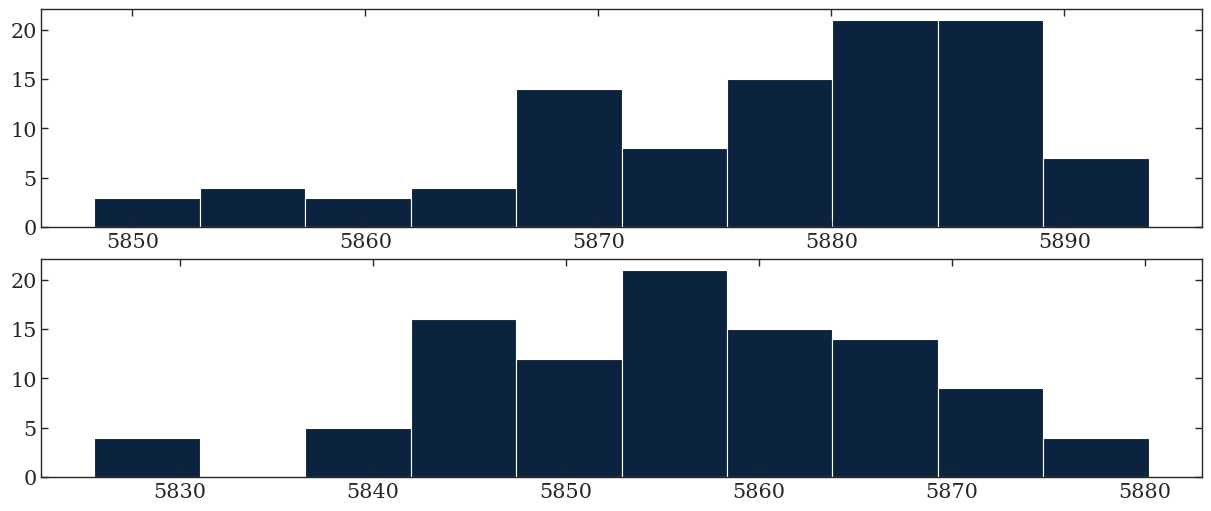

In [5]:
fig, axs = plt.subplots(2)
axs[0].hist(point1)
axs[1].hist(point2)

# Single observation

In [6]:
def assimilate(prior, y, sigma_y):
    K = prior.var() / (prior.var() + sigma_y**2)
    posterior_std = np.sqrt((1 - K) * prior.var())
    posterior_mean = prior.mean() + K * (y - prior.mean())
    posterior = norm(posterior_mean, posterior_std)
    return posterior

In [7]:
def plot_pdf(ax, dist, lim=0.0001, **kwargs):
    x = np.linspace(dist.ppf(lim), dist.ppf(1 - lim), 100)
    ax.plot(x, dist.pdf(x), **kwargs)

In [8]:
def assimilate_single_and_plot(point, lat, name, show_legend=True):
    sigma_y = np.sqrt(10)

    x_true = point[0]
    y = x_true + norm.rvs(0, sigma_y, random_state=default_rng(int(14154567554 + point[0] + lat)))
    ensemple_prior_samples = point[1:]
    ensemble_prior = norm(*norm.fit(ensemple_prior_samples))
    ensemble_posterior = assimilate(ensemble_prior, y, sigma_y)

    fig, ax = plt.subplots(figsize=(12, 4))

    plot_pdf(ax, ensemble_prior, label="Prior")

    jitter_max = ax.get_ylim()[1] * 0.05
    ax.scatter(ensemple_prior_samples, np.random.uniform(0, jitter_max, ensemple_prior_samples.shape), c="C0", label="Prior samples")
    
    plot_pdf(ax, ensemble_posterior, label="Posterior")
    ax.scatter(y, jitter_max / 2, c="C2", label="Observation")
    plot_pdf(ax, norm(y, sigma_y), label="Observation dist.")
    ax.axvline(x_true, color="C2", alpha=0.5, label="True value", ls="--")

    if show_legend:
        ax.legend()
        
    ax.set_xlabel("Z500 [m]")
    ax.set_ylabel("Probability density")

    format_plot()
    save_plot("../latex/hw3/figures", name)

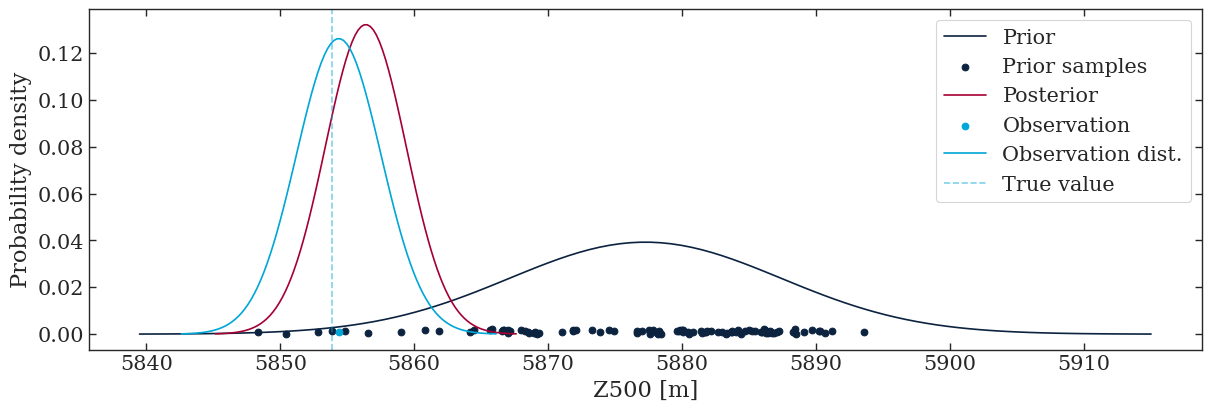

In [9]:
assimilate_single_and_plot(point1, lat1, "single_point1")

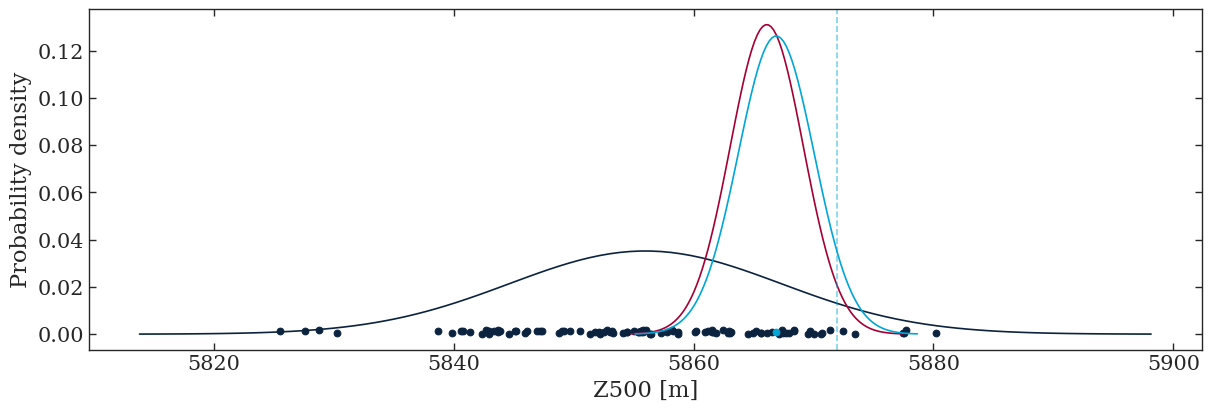

In [10]:
assimilate_single_and_plot(point2, lat2, "single_point2", show_legend=False)

# Multiple observations

In [11]:
def assimilate_multiple(point, lat, sigma_y, seed_inc=0, N_obs = 100):
    x_true = point[0]
    initial_prior_samples = point[1:]
    initial_prior = norm(*norm.fit(initial_prior_samples))
    prior = initial_prior

    rng = default_rng(int(14154567554 + point[0] + lat + seed_inc))
    obs = []
    posteriors = []
    priors = []
    for i in range(N_obs):
        priors.append(prior)

        y = x_true + norm.rvs(0, sigma_y, random_state=rng)
        obs.append(y)
        posterior = assimilate(prior, y, sigma_y)
        prior = posterior

        posteriors.append(posterior)

    return N_obs, x_true, obs, priors, posteriors

In [12]:
def assimilate_multiple_and_plot(point, lat, sigma_y, name, show_legend=True):
    N_obs, x_true, obs, priors, posteriors = assimilate_multiple(point, lat, sigma_y)

    fig, ax = plt.subplots(figsize=(12, 4))

    plot_pdf(ax, priors[0], lim=0.001, label="Initial prior")

    cmap = mpl.colors.LinearSegmentedColormap.from_list("reds", [
        mpl.colors.to_rgb("white"),
        mpl.colors.to_rgb("C1"),
    ])(np.linspace(0.3, 1, N_obs))
    
    for i, posterior in enumerate(posteriors):
        if i < 5 or (i % 10 == 9 and i < N_obs - 1):
            if i == 49:
                label = "Intermediate posteriors"
            else:
                label = None
            plot_pdf(ax, posterior, color=cmap[i], ls=":", label=label)
    
    plot_pdf(ax, posterior, color="C1", label="Final posterior")

    jitter_max = ax.get_ylim()[1] * 0.05
    ax.scatter(obs, np.random.uniform(0, jitter_max, len(obs)), c="C2", label="Observations")
    ax.axvline(x_true, color="C2", alpha=0.5, label="True value", ls="--")

    if show_legend:
        ax.legend()
        
    ax.set_xlabel("Z500 [m]")
    ax.set_ylabel("Probability density")

    format_plot()
    save_plot("../latex/hw3/figures", name)

## $\sigma_y^2 = 10$

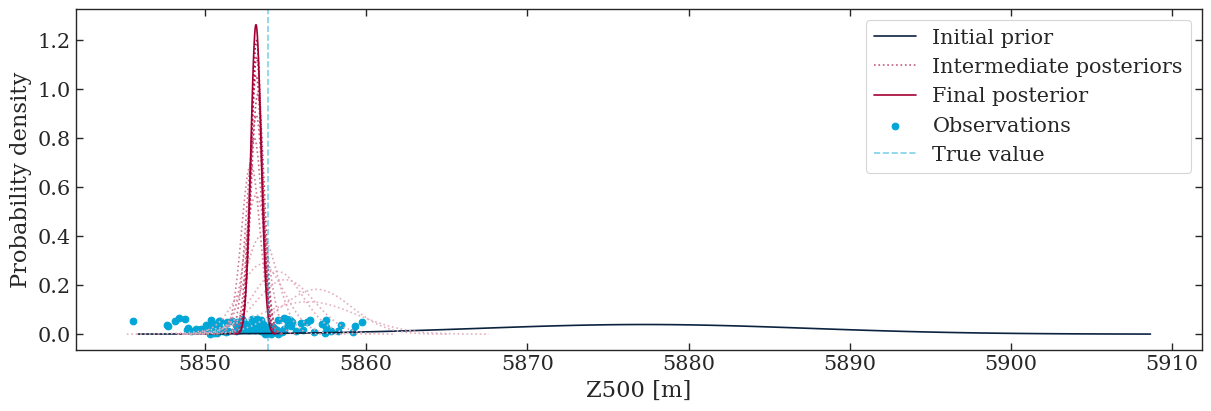

In [13]:
assimilate_multiple_and_plot(point1, lat1, np.sqrt(10), "multiple_point1_var10")

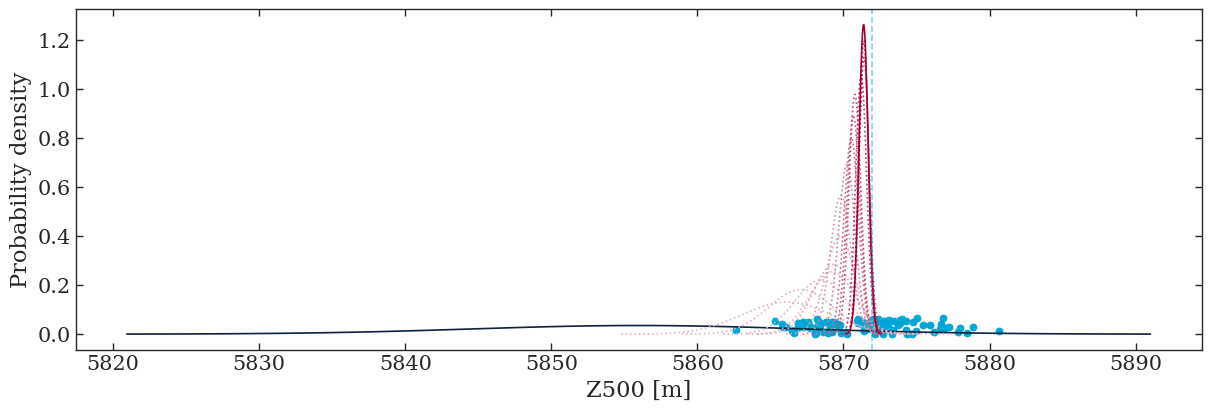

In [14]:
assimilate_multiple_and_plot(point2, lat2, np.sqrt(10), "multiple_point2_var10", show_legend=False)

In [15]:
def plot_statistics_evolution(point, lat, sigma_y, name, seed_offset=0, show_legend=True):
    var_of_prior_errors = []
    var_of_posterior_errors = []
    mean_vars = []

    x_trues = []
    priorss = []
    posteriorss = []

    N_reps = 100
    N_obs = 100

    for i in range(N_reps):
        _, x_true, _, priors, posteriors = \
            assimilate_multiple(point, lat, sigma_y, N_obs=N_obs, seed_inc=i+seed_offset)
        x_trues.append(x_true)
        priorss.append(priors)
        posteriorss.append(posteriors)
    
    for i in range(N_obs):
        prior_errors = []
        posterior_errors = []
        variances = []
        for j in range(N_reps):
            prior_errors.append(x_trues[j] - priorss[j][i].mean())
            posterior_errors.append(x_trues[j] - posteriorss[j][i].mean())
            variances.append(posteriorss[j][i].var())

        var_of_prior_errors.append(np.var(prior_errors, ddof=1))
        var_of_posterior_errors.append(np.var(posterior_errors, ddof=1))
        mean_vars.append(np.mean(variances))
    
    print(f"Error variance of final posterior mean: {var_of_posterior_errors[-1]}")
    print(f"Mean variance of final posterior: {mean_vars[-1]}")

    fig, ax = plt.subplots(figsize=(12, 5))

    xx = np.arange(N_obs) + 1
    ax.plot(xx, mean_vars, ls=":", c="C2", label="Mean variance of posteriors")
    ax.plot(xx[1:], var_of_prior_errors[1:], c="C0", label="Variance of prior errors")
    ax.plot(xx, var_of_posterior_errors, c="C1", label="Variance of posterior errors")

    ax.set_xlabel("Number of observations assimilated")
    ax.set_ylabel("Variance/error [$m^2$]")
    ax.set_yscale("log")

    if show_legend:
        ax.legend()

    format_plot()
    save_plot("../latex/hw3/figures", name)

In [16]:
plot_statistics_evolution(point1, lat1, np.sqrt(10), "stats_point1_var10")

Error variance of final posterior mean: 0.12015991960618837
Mean variance of final posterior: 0.09992225338831377


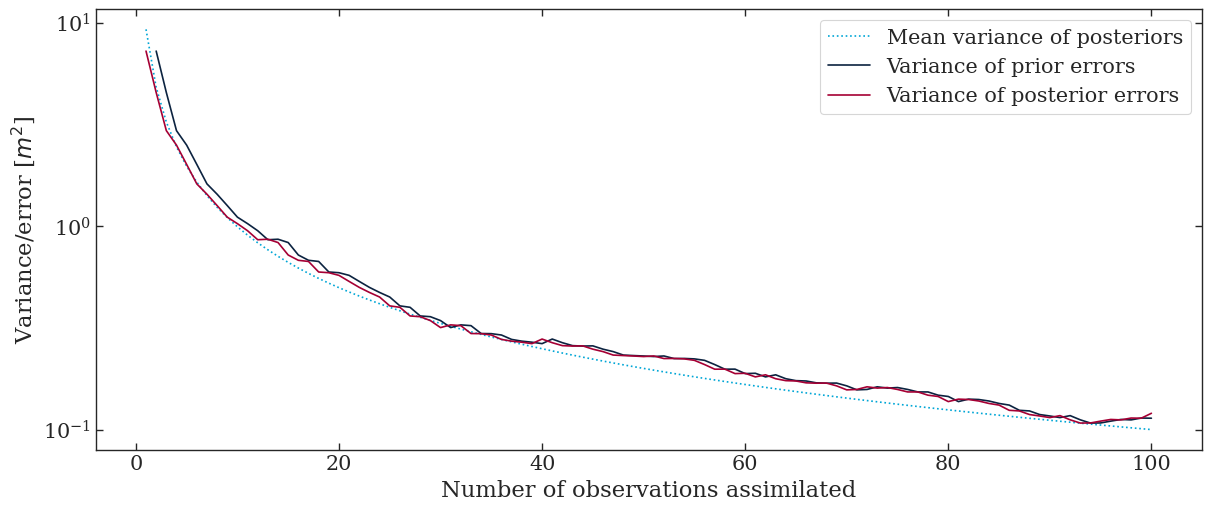

In [ ]:
plot_statistics_evolution(point2, lat2, np.sqrt(10), "stats_point2_var10", seed_offset=1e6)

## $\sigma_y^2 = 0.01$

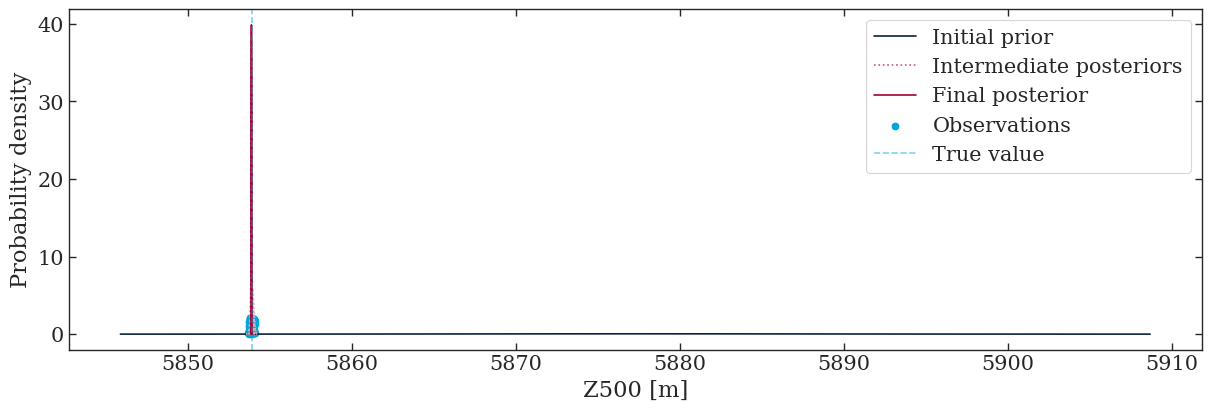

In [ ]:
assimilate_multiple_and_plot(point1, lat1, np.sqrt(0.01), "multiple_point1_var01")

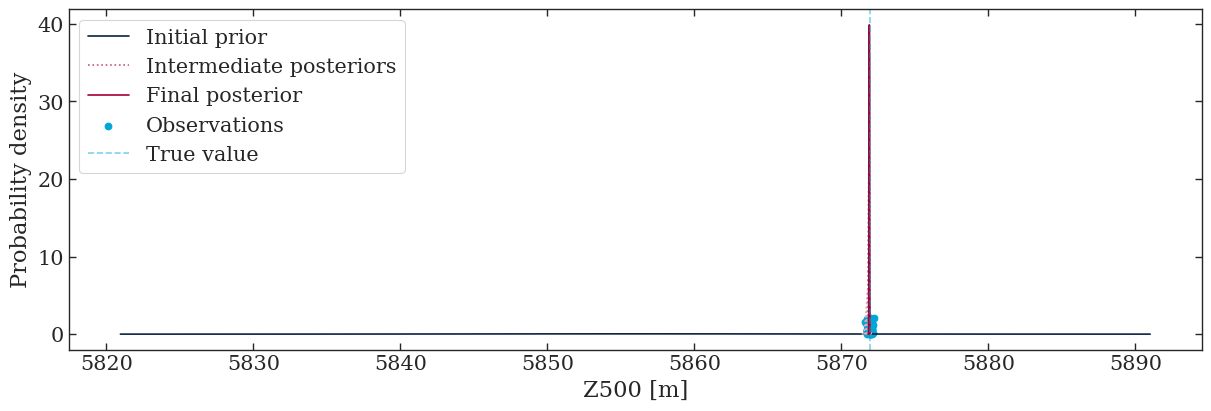

In [ ]:
assimilate_multiple_and_plot(point2, lat2, np.sqrt(0.01), "multiple_point2_var01")

Error variance of final posterior mean: 8.479514618677412e-05
Mean variance of final posterior: 9.999990312143137e-05


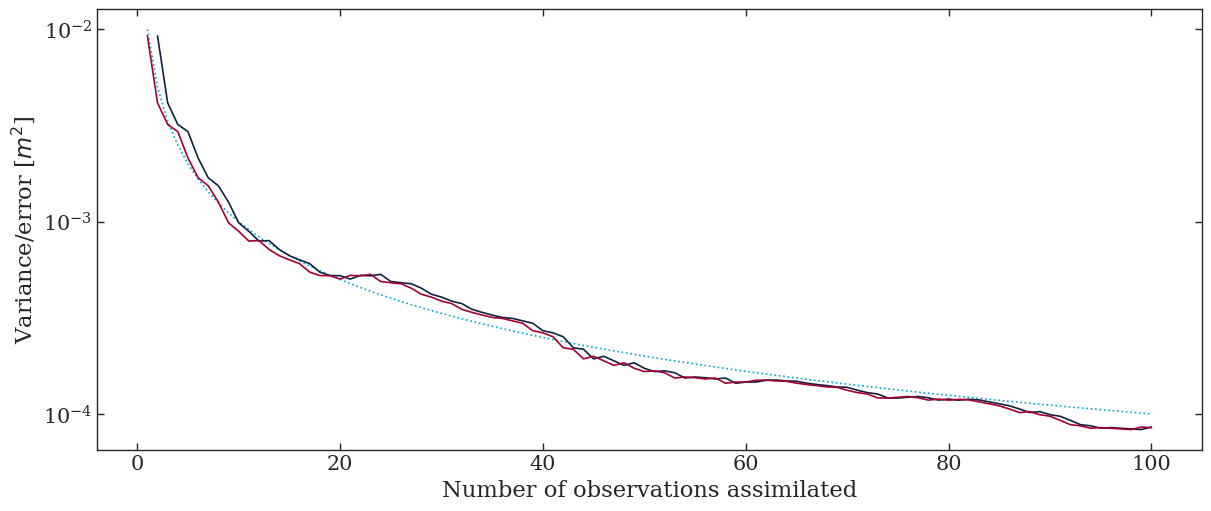

In [ ]:
plot_statistics_evolution(point1, lat1, np.sqrt(0.01), "stats_point1_var01", show_legend=False, seed_offset=1e7)

Error variance of final posterior mean: 0.00010473102201528173
Mean variance of final posterior: 9.999992219295499e-05


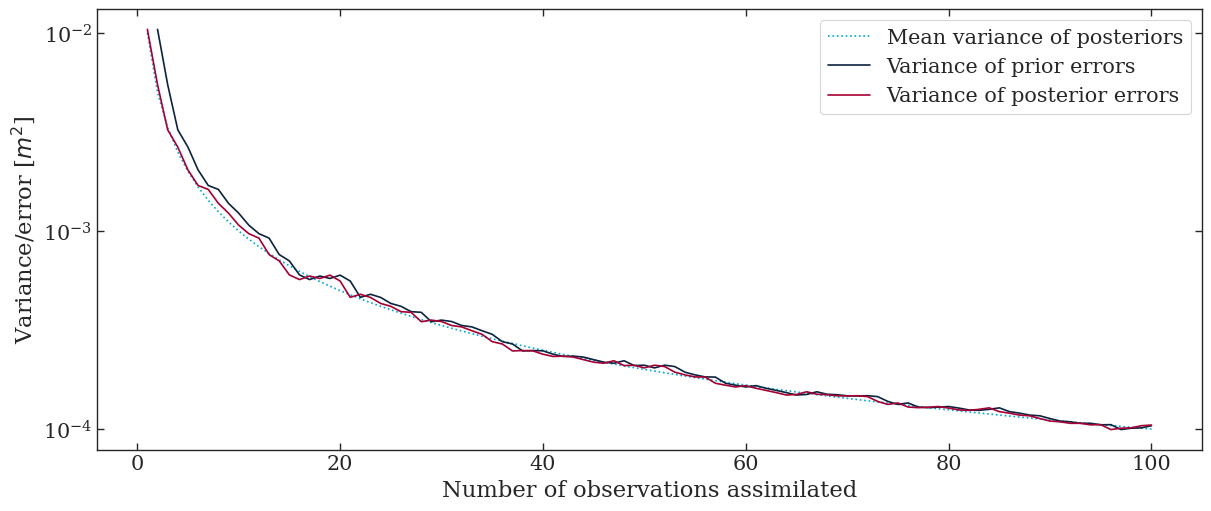

In [ ]:
plot_statistics_evolution(point2, lat2, np.sqrt(0.01), "stats_point2_var01", seed_offset=1e8)

# Multiple vector

In [ ]:
def assimilate_vector(prior, y, y_var, obs_point):
    N = len(prior.mean)
    H = np.zeros((1, N))
    H[0, obs_point-1] = 1
    R = np.array([[y_var]])
    K = prior.cov @ H.T @ np.linalg.inv(H @ prior.cov @ H.T + R)
    posterior_cov = (np.identity(N) - K @ H) @ prior.cov
    posterior_mean = prior.mean + K @ (y - H @ prior.mean)
    posterior = multivariate_normal(posterior_mean, posterior_cov)
    return posterior

In [ ]:
def plot_joint_pdf(ax, dist, sigma = 5, cmap=None, **kwargs):
    assert len(dist.mean) == 2
    
    max_std = np.sqrt(np.max(np.diag(dist.cov)))
    x1 = np.linspace(
        dist.mean[0] - sigma * max_std,
        dist.mean[0] + sigma * max_std,
        100)
    x2 = np.linspace(
        dist.mean[1] - sigma * max_std,
        dist.mean[1] + sigma * max_std,
        100)
    xx = np.meshgrid(x1, x2)

    levels = []
    colors = []
    max_sigma = 3
    for sigma in np.arange(1, max_sigma+1, 1):
        levels.append(dist.pdf(dist.mean + sigma * np.sqrt(np.diag(dist.cov))))
        colors.append(cmap(1 - 0.6 * (sigma - 1) / (max_sigma - 1)))

    ax.contour(
        x1, x2, dist.pdf(np.dstack(xx)),
        levels=list(reversed(levels)), colors=list(reversed(colors)), **kwargs)

In [ ]:
def plot_univariate_pdf(ax, dist, obs_point, add_label=False, **kwargs):
    cmap_obs = mpl.colors.LinearSegmentedColormap.from_list("cmap", [
        mpl.colors.to_rgb("white"),
        mpl.colors.to_rgb("C2"),
    ])
    max_sigma = 2
    for sigma in range(-max_sigma, max_sigma + 1):
        axline = ax.axvline if obs_point == 1 else ax.axhline
        color = cmap_obs(1 - 0.6 * np.abs(sigma) / max_sigma)
        label = "Observation dist." if (add_label and sigma == 0) else None
        axline(dist.mean() + sigma * np.sqrt(dist.var()), color=color, label=label, **kwargs)

In [ ]:
def assimilate_vector_and_plot(ensemble_samples, sigma_y, name, obs_point, show_legend=True):
    x_true = ensemble_samples[:, 0]
    prior_samples = ensemble_samples[:, 1:]
    prior = multivariate_normal(
        np.mean(prior_samples, axis=1), np.cov(prior_samples))

    rng = default_rng(int(141425456754 + obs_point + 0))
    obs_dist = norm(x_true[obs_point-1], sigma_y)
    obs = obs_dist.rvs(random_state=rng).T
    posterior = assimilate_vector(prior, obs, obs_dist.var(), obs_point)
    
    print("Prior mean:", prior.mean)
    print("Posterior mean:", posterior.mean)
    print("Difference in means:", posterior.mean - prior.mean)
    print()
    print("Prior vars:", prior.cov)
    print("Posterior vars:", posterior.cov)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    cmap_prior = mpl.colors.LinearSegmentedColormap.from_list("cmap", [
        mpl.colors.to_rgb("white"),
        mpl.colors.to_rgb("C0"),
    ])
    cmap_posterior = mpl.colors.LinearSegmentedColormap.from_list("cmap", [
        mpl.colors.to_rgb("white"),
        mpl.colors.to_rgb("C1"),
    ])

    ax1line = ax1.axvline if obs_point == 1 else ax1.axhline
    ax2line = ax2.axvline if obs_point == 1 else ax2.axhline

    plot_joint_pdf(ax1, prior, cmap=cmap_prior)
    ax1.scatter(ensemble_samples[0, 1:], ensemble_samples[1, 1:], c="C0", label="Prior samples")
    plot_univariate_pdf(ax1, obs_dist, obs_point, ls=":", add_label=True)
    ax1line(obs, color="C2", label="Observation")

    plot_joint_pdf(ax2, prior, cmap=cmap_prior)
    ax2.scatter(*prior.mean, c="C0", marker="x", label="Prior mean")
    plot_joint_pdf(ax2, posterior, cmap=cmap_posterior)
    plot_univariate_pdf(ax2, obs_dist, obs_point, ls=":")
    ax2.scatter(*posterior.mean, c="C1", marker="x", label="Posterior mean")
    ax2line(obs, color="C2")

    ax1.set_xlabel("Z500 at Point 1 [m]")
    ax1.set_ylabel("Z500 at Point 2 [m]")
    ax1.set_aspect("equal")
    ax2.set_aspect("equal")

    if show_legend:
        h, l = ax1.get_legend_handles_labels()
        h.insert(0, mpl.lines.Line2D([0], [0], color="C0"))
        l.insert(0, "Prior")
        ax1.legend(h, l)

        h, l = ax2.get_legend_handles_labels()
        h.insert(0, mpl.lines.Line2D([0], [0], color="C1"))
        l.insert(0, "Posterior")
        ax2.legend(h, l)

    format_plot()
    save_plot("../latex/hw3/figures", name)

Prior mean: [5877.26295753 5855.98107653]
Posterior mean: [5852.344389   5847.57223622]
Difference in means: [-24.91856853  -8.40884031]

Prior vars: [[104.27518778  35.18795238]
 [ 35.18795238 129.83442755]]
Posterior vars: [[  9.1249194    3.07922945]
 [  3.07922945 118.99924961]]


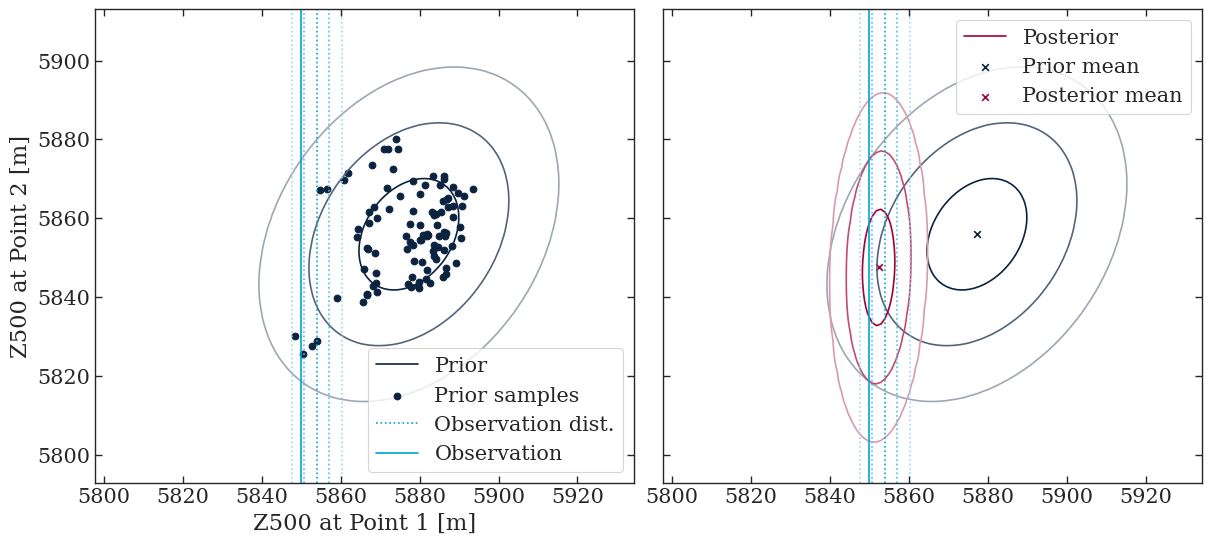

In [ ]:
assimilate_vector_and_plot(np.vstack([point1, point2]), np.sqrt(10), "vector_1", 1)

Prior mean: [5877.26295753 5855.98107653]
Posterior mean: [5881.70891305 5872.38550053]
Difference in means: [ 4.44595552 16.40442399]

Prior vars: [[104.27518778  35.18795238]
 [ 35.18795238 129.83442755]]
Posterior vars: [[95.42048716  2.51640122]
 [ 2.51640122  9.28486853]]


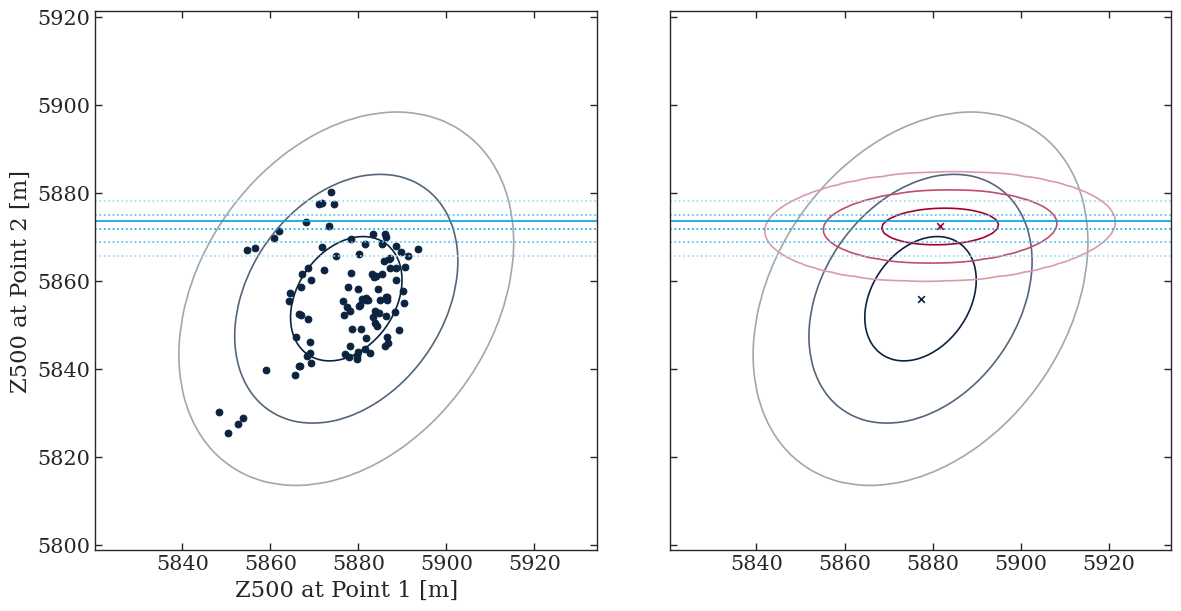

In [ ]:
assimilate_vector_and_plot(np.vstack([point1, point2]), np.sqrt(10), "vector_2", 2, show_legend=False)